In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.optimizers import *
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import joblib

# Used CSV Files in This Notebook Can Be Reached Via The Link Given Below
https://drive.google.com/drive/folders/1LJBghznfrr3SfxHZ8sUenAc6pdhb5vKK?usp=sharing

# Read Dataset

In [2]:
df = pd.read_csv('C:/Users/norma/Desktop/BİTİRME/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
# Keeping only 2 classes which are AD and CTL
df = df[df.Class != 2]

In [3]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

# PCA

In [4]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size = 0.22, random_state=41)

# Select Optimal Parameters With GridSearchCV

In [6]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [7]:
# print best parameter after tuning
print(bestF.best_params_)

print('\n')

# print how our model looks after hyper-parameter tuning
print(bestF.best_estimator_)

{'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 500}


RandomForestClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=5,
                       n_estimators=500)


In [13]:
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]

hyperF = dict(criterion=criterion, max_features=max_features)

gridF = GridSearchCV(RandomForestClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=5,
                       n_estimators=500), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [14]:
# print best parameters after tuning
print(bestF.best_params_)

print('\n')

# print how our model looks after hyper-parameter tuning
print(bestF.best_estimator_)

{'criterion': 'gini', 'max_features': 'sqrt'}


RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=5, n_estimators=500)


In [15]:
grid_predictions = bestF.predict(x_test)

# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.54      0.92      0.68        87
           1       0.88      0.43      0.58       122

   micro avg       0.64      0.64      0.64       209
   macro avg       0.71      0.68      0.63       209
weighted avg       0.74      0.64      0.62       209
 samples avg       0.64      0.64      0.64       209



In [16]:
class_d = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test_ = encoder.inverse_transform(y_test).ravel()

# The Optimal Random Forest Model

In [20]:
clf = RandomForestClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=5, criterion = 'gini', max_features = 'sqrt',
                       n_estimators=300)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

y_pred_ = np.argmax(y_pred, axis=1)

# Confusion Matrix

Classification report : 
               precision    recall  f1-score   support

           0       0.55      0.92      0.69        87
           1       0.89      0.47      0.61       122

    accuracy                           0.66       209
   macro avg       0.72      0.69      0.65       209
weighted avg       0.75      0.66      0.64       209



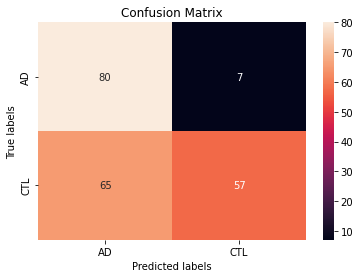

In [21]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test_, y_pred_, labels=[0,1])
print('Classification report : \n',matrix)

labels_ = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test_, y_pred_)

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels_);

# AUC-ROC

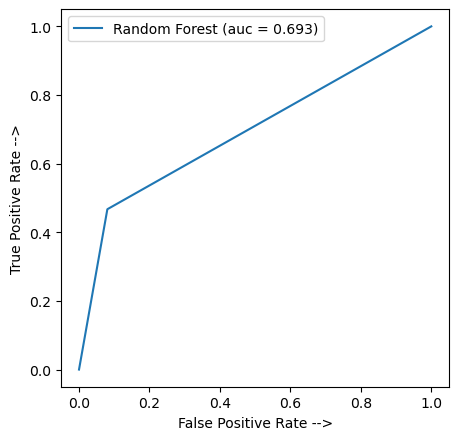

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_, y_pred[:,1])
auc_rf = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'Random Forest (auc = %0.3f)' % auc_rf)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Save Model

In [23]:
filename = 'C:/Users/norma/Desktop/src/RANDOM_FOREST.h5'
joblib.dump(clf, filename)

['C:/Users/norma/Desktop/src/RANDOM_FOREST.h5']

# Load Model

In [24]:
# Load the model from the file
rf = joblib.load(filename)
 
# Use the loaded model to make predictions
y_pred_load = rf.predict(x_test)

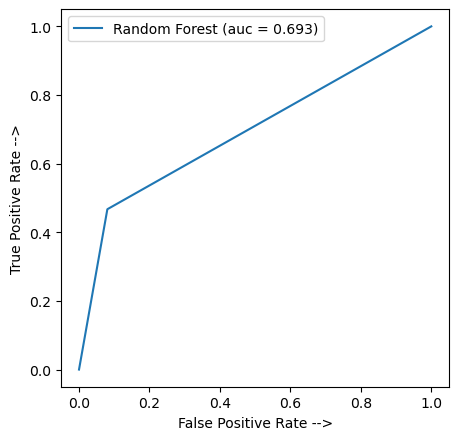

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_, y_pred_load[:,1])
auc_rf = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'Random Forest (auc = %0.3f)' % auc_rf)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()